# Gradually increase the n_sats 
> Work in progress

In [3]:
from modules.golomb_problem import init_simple_problem, orbital_golomb_array
from modules.gradually_increase_difficulty import increase_difficulty

##### Template

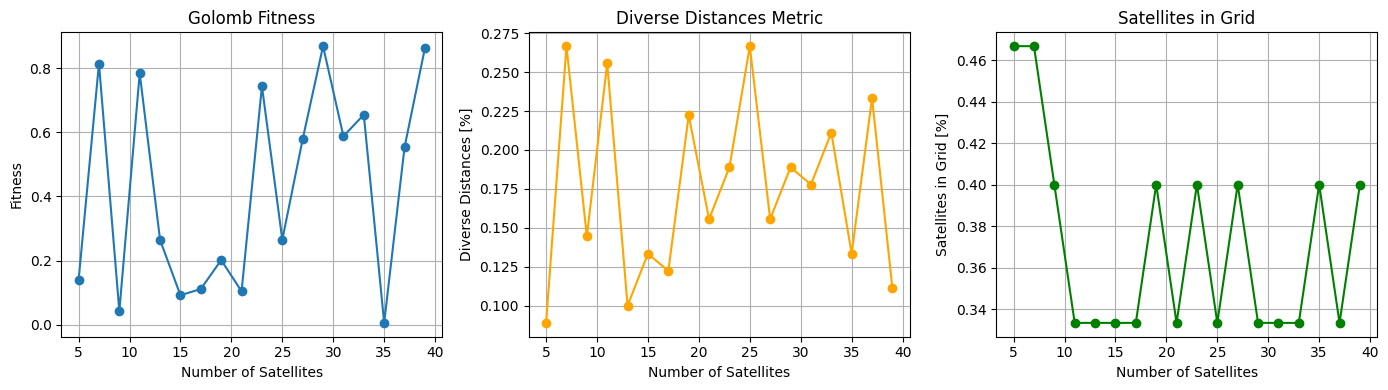

| N_sats | Fitness | Diverse Distances [%] | Satellites in Grid [%] | 
|---|---|---|---|
| 5 | 0.1389 | 0.0889 | 0.4667 |
| 7 | 0.8147 | 0.2667 | 0.4667 |
| 9 | 0.0418 | 0.1444 | 0.4000 |
| 11 | 0.7848 | 0.2556 | 0.3333 |
| 13 | 0.2642 | 0.1000 | 0.3333 |
| 15 | 0.0916 | 0.1333 | 0.3333 |
| 17 | 0.1112 | 0.1222 | 0.3333 |
| 19 | 0.2016 | 0.2222 | 0.4000 |
| 21 | 0.1038 | 0.1556 | 0.3333 |
| 23 | 0.7439 | 0.1889 | 0.4000 |
| 25 | 0.2649 | 0.2667 | 0.3333 |
| 27 | 0.5787 | 0.1556 | 0.4000 |
| 29 | 0.8690 | 0.1889 | 0.3333 |
| 31 | 0.5880 | 0.1778 | 0.3333 |
| 33 | 0.6551 | 0.2111 | 0.3333 |
| 35 | 0.0054 | 0.1333 | 0.4000 |
| 37 | 0.5536 | 0.2333 | 0.3333 |
| 39 | 0.8630 | 0.1111 | 0.4000 |


In [4]:
UDP = init_simple_problem()
n_sats_range = range(5, 40, 2)


def optimizer(UDP: orbital_golomb_array, sats: int, verbose) -> tuple[float, list[float]]:
    import time
    import random
    if verbose:
        print("amongoose")
        print("n_sats = ", sats)
    time.sleep(1)

    return (random.random(), [random.random() for i in range(0, sats * 6)])

ret = increase_difficulty(UDP, n_sats_range, optimizer, file_name=None, verbose=True)
del ret

## Non-Dominated Sorting Genetic Algorithm

In [10]:
import numpy as np
import pygmo as pg
from modules.golomb_problem import init_simple_problem, orbital_golomb_array
#from modules.plotter import print_result


# Classe del problema per NSGA-II
class GolombOptimization:
    def __init__(self, udp, n_sat):
        """
        Classe che rappresenta il problema multi-obiettivo.
        udp: il problema originale esistente.
        n_sat: numero di satelliti.
        """
        self.udp = udp
        self.n_var = n_sat * 6  # Numero di variabili
        self.n_obj = 2  # Obiettivi multipli
        self.bounds = ([-0.5] * self.n_var, [0.5] * self.n_var)

    def fitness(self, x):
        """
        Calcola le funzioni obiettivo:
        - f1: Fitness originale del problema.
        - f2: Varianza negativa delle posizioni.
        """
        f1 = self.udp.fitness(x)[0]  # Fitness originale
        positions = np.array(x).reshape(-1, 6)[:, :3]  # Estrarre posizioni XYZ
        f2 = -np.var(positions)  # Varianza negativa delle posizioni
        return [f1, f2]

    def get_bounds(self):
        return self.bounds

    def get_nobj(self):
        return self.n_obj

# Ottimizzatore basato su NSGA-II
def nsga2_optimizer(udp: orbital_golomb_array, n_sats: int) -> tuple[float, list[float]]:
    """
    Configura ed esegue l'ottimizzazione NSGA-II per il numero dato di satelliti.
    """
    problem = pg.problem(GolombOptimization(udp, n_sats))
    algorithm = pg.algorithm(pg.nsga2(gen=100))  # 100 generazioni di default
    population = pg.population(problem, size=300)  # Popolazione iniziale
    population = algorithm.evolve(population)

    # Estrai il fronte di Pareto
    pareto_fitness = population.get_f()
    pareto_vectors = population.get_x()

    # Seleziona la soluzione migliore rispetto al primo obiettivo
    best_idx = np.argmin(pareto_fitness[:, 0])
    best_solution = pareto_vectors[best_idx]
    best_fitness = pareto_fitness[best_idx][0]
    #print_result(udp, best_solution, 300, show_simulated_reconstruction=True)
    return best_fitness, best_solution


# Esecuzione principale
if __name__ == "__main__":
    UDP = init_simple_problem()  # Inizializza il problema
    
    n_sats_range = range(5, 40, 5)  # Incremento di difficoltà: 5 -> 10 -> ... -> 35

    # Esegui l'ottimizzazione dinamica
    ret = increase_difficulty(UDP, n_sats_range, nsga2_optimizer)
    del ret

Optimization Progress:  14%|█▍        | 1/7 [00:55<05:35, 55.92s/it]

### Ottimizzazione per 10 satelliti...

| N | Fitness | Solution      |
|---|---|---|
| 5 | -0.13832 | [-0.18, 0.16, 0.04, 0.19, -0.18, 0.4, 0.33, -0.49, 0.37, -0.05, -0.14, -0.15, 0.49, -0.49, -0.5, -0.16, -0.06, -0.35, 0.5, 0.49, -0.49, 0.36, 0.12, 0.44, -0.43, 0.5, -0.5, 0.44, -0.49, 0.29] |


Optimization Progress:  14%|█▍        | 1/7 [01:15<07:33, 75.61s/it]


KeyboardInterrupt: 

## Grey Wolf

## Differencial Evolution